In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve,auc

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('../data/haberman_csv.csv')

In [3]:
df.columns

Index(['Age_of_patient_at_time_of_operation', 'Patients_year_of_operation',
       'Number_of_positive_axillary_nodes_detected', 'Survival_status'],
      dtype='object')

In [4]:
df=df.drop(columns=['Patients_year_of_operation'])

In [5]:
df.shape

(306, 3)

In [6]:
df=df.rename(columns={'Age_of_patient_at_time_of_operation':'age', 'Number_of_positive_axillary_nodes_detected':'detections'})

In [7]:
data=df.values
X=data[:,:2]
Y=data[:,2]

In [8]:
X_train,x_test,Y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=9)

In [9]:
pure_region_generated_sample=pd.read_csv('pure_region_sample.csv')#extra generated data

In [10]:
pure_region_data=np.array(pure_region_generated_sample)

In [11]:
extra_X=pure_region_data[:,:2]

In [12]:
extra_X[:5]

array([[33.0279125 ,  9.01293564],
       [30.95839742,  8.20819424],
       [32.15762497,  8.48354281],
       [30.6591487 ,  9.02242689],
       [33.86724446,  9.3748133 ]])

In [13]:
extra_Y=pure_region_data[:,2]

In [14]:
extra_Y[:5]

array([2., 2., 2., 2., 2.])

In [15]:
X_train_with_extra=np.concatenate((X_train,extra_X),axis=0)

In [16]:
Y_train_with_extra=np.concatenate((Y_train,extra_Y),axis=0)

In [17]:
tree=DecisionTreeClassifier(random_state=9)

tree_params={'max_depth':[3,4,5,6],'max_features':[1,2]}

tree_grid=GridSearchCV(tree,tree_params,scoring='accuracy',n_jobs=-1,cv=10,verbose=2)

tree_grid.fit(X_train_with_extra,Y_train_with_extra)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.3s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=9,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6], 'max_features': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [18]:
import pydotplus
from sklearn.tree import export_graphviz

def draw_tree(tree,features,location):
    tree_string=export_graphviz(tree,feature_names=features,filled=True,out_file=None)
    graph=pydotplus.graph_from_dot_data(tree_string)
    graph.write_png(location)

In [19]:
draw_tree(tree_grid.best_estimator_,['age', 'detections'],\
          location='../imgs/tree_grid1_with_extra.png')

<img src='../imgs/tree_grid1_with_extra.png'>

In the above pictures red circled leaves contains samples from minority class only. So, if we extract rules following the green line and replicate samples within those rules, I believe it will fall in the same pure regions.

In [20]:
best_tree=tree_grid.best_estimator_

In [21]:
best_tree.score

<bound method ClassifierMixin.score of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=9, splitter='best')>

In [24]:
tree_grid.best_score_# it was earlier 0.7383177570093458

0.7965616045845272

In [28]:
accuracy_score(y_test,tree_grid.predict(x_test))# it was earlier: 0.6847826086956522

0.7065217391304348

In [29]:
import SampleExtraction

In [30]:
pure_samples_X_train,pure_samples_with_class,rules_with_pure_class=SampleExtraction.pure_sample_extraction(best_tree,X_train,Y_train,2)

In [31]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [32]:
pure_X_train=np.array(pure_samples_X_train)

ValueError: c of shape (214,) not acceptable as a color sequence for x with size 135, y with size 135

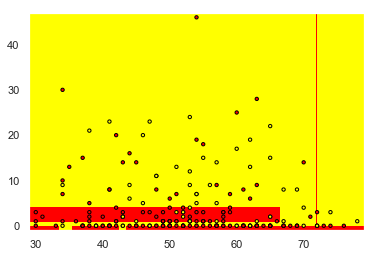

In [38]:
xx,yy=get_grid(X_train)

predicted1=best_tree.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx,yy,predicted1,cmap='autumn')
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,s=11,cmap='autumn',edgecolors='black')
plt.scatter(extra_X[:,0],extra_X[:,1],c=Y_train,s=16,cmap='spring',edgecolors='green')
plt.scatter(pure_X_train[:,0],pure_X_train[:,1],s=20,cmap='spring',edgecolors='blue')
plt.legend()

In the above picture, blue dots represents samples of pure minority class that followed the rules colored green in the Decision Tree.

Yellow dots also represents minority class and Red dots represents majority class.
It is clear from the picture that rules in decision tree that generates leaves containing pure minority samples also make regions that are pure and contains no majority samples thus providing pure regions of minority class(representing rules that leads to leaves containing only minority class samples).

It roughly provides samples of minority class where oversampling will be safe. Decision rules that provide these pure regions can be used for oversampling.